In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift

In [2]:
%%bash

ulimit -n 4098

In [3]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        print('Spectrum file missing...')
        return
    return lam,flux,fluxsig

In [4]:
filetable = Table.read('filetable.fits')
wdtable = Table.read('tremblay_final.fits')
print(len(wdtable))
wdtable = join(filetable,wdtable,keys = ['source_id','Teff','log_g','spectral_class','S/N'])

DA = (wdtable['spectral_class'] == 'DA')*(~np.isnan(wdtable['Teff']))*(~np.isnan(wdtable['log_g']))*\
        (wdtable['S/N'] > 55)*(wdtable['spec_Teff'] < 80000)
wdtable = wdtable[DA]
len(wdtable)

5396


105

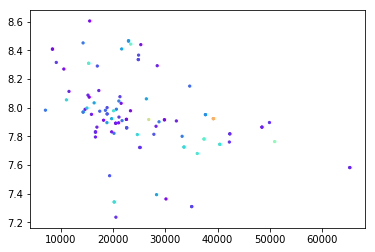

In [5]:
plt.scatter(wdtable['spec_Teff'],wdtable['spec_logg'], s = 5, c = wdtable['S/N'], vmax = 100, cmap = 'rainbow')

In [11]:
interpfluxs = [];
sigs = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(wdtable))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    sig = spec[2]
    func2 = interp1d(lam,sig,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpsig = func2(lamgrid)
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)
    sigs.append(interpsig)

100%|██████████| 105/105 [00:07<00:00, 14.62it/s]


In [16]:
spectra = np.asarray(interpfluxs)
sigs = np.asarray(sigs)
continuum = pickle.load(open('continuumwls.p','rb'))
lamgrid = np.arange(4000,8000)

In [59]:
def adapted_ch_cont(array,continuum,sigarray = None):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],5)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    if sigarray is not None:
        contsigarray = sigarray / np.polynomial.chebyshev.chebval(lamgrid,p)
        return contcorr,contsigarray
    return contcorr

In [54]:
def norm_dataspec(array,sigarray=None):
    contcorr,contsig = adapted_ch_cont(array,continuum,sigarray)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    contcorr[where] = 1
    return contcorr,contsig

In [47]:
wdtable['spectrum'] = spectra

In [48]:
clamgrid = np.linspace(4000,7000,3000)

In [49]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


In [50]:
sc = pickle.load(open('koesterddsc.p','rb'))
msc = pickle.load(open('koesterddmsc.p','rb'))

In [52]:
H = 128
def generator():
    x = Input(shape=(2,))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deep.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 4000)              516000    
Total params: 565,920
Trainable params: 565,920
Non-trainable params: 0
_________________________________________________________________
None

Text(0.5, 0, 'Wavelength ($\\AA$)')

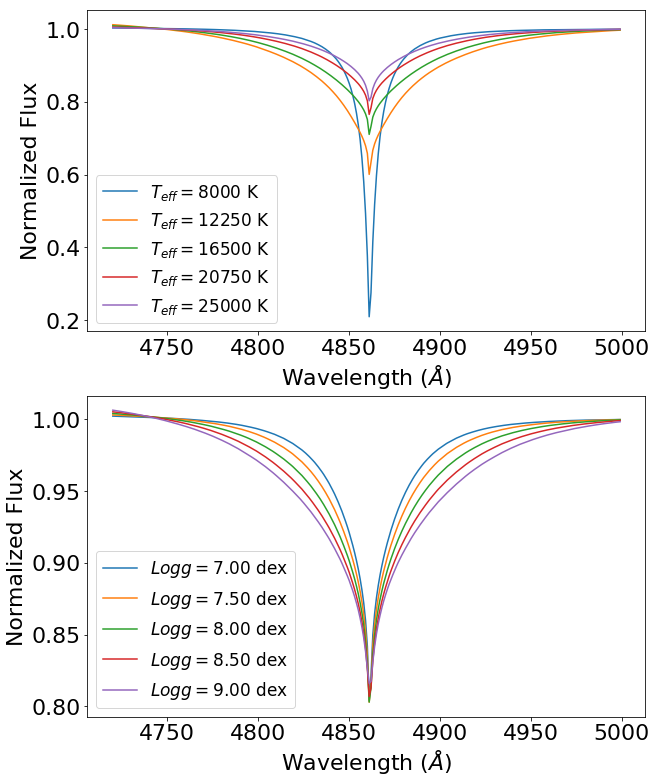

In [57]:
plt.figure(figsize=(10,13))

plt.subplot(211)
ts = np.linspace(8000,25000,5)
ls = np.linspace(8,8,5)
plt.rcParams.update({'font.size': 22})             
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],adapted_ch_cont(gens[i],continuum)[720:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.subplot(212)
ts = np.linspace(25000,25000,5)
ls = np.linspace(7,9,5)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],adapted_ch_cont(gens[i],continuum)[720:1000],label='$Logg = %.2f$ dex'%ls[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

# Fitting

In [221]:
lines = ((lamgrid > hbeta-200) & (lamgrid < hbeta + 300)) | ((lamgrid > halpha-250) & (lamgrid < halpha + 300))\
        | ((lamgrid > hgamma-120) & (lamgrid < hgamma + 400))| ((lamgrid > hdelta-90) & (lamgrid < hdelta + 150))

def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    synth = dopplerShift(wl,np.ravel(
                        msc.inverse_transform(
                                model.predict(label))[0]
                        ), trans*1000
                    )[0]
    return np.exp(np.ravel(synth).astype('float64'))

def norm_spectrum_sampler(wl,teff,logg,trans):
    synth = spectrum_sampler(lamgrid,teff,logg,trans)
    return adapted_ch_cont(synth,continuum)[lines]

def chisquare(residual):
    return sum(residual**2)

def get_prior_teff(array):
    spec = np.asarray(array)
    priorfitter = lmfit.Model(spectrum_sampler)
    priorparams = priorfitter.make_params()
    priorparams['logg'].set(value = 8., vary = False)
    priorparams['teff'].set(value = 10000,min = 5500, max = 80000)
    priorparams['trans'].set(value = 0., vary = False)
    priorfitter.eval(priorparams, wl = lamgrid)
    prior_result = priorfitter.fit(spec, priorparams, wl = lamgrid, method = 'Powell', nan_policy = 'omit');
    #print(prior_result.fit_report())
    return prior_result.params['teff'].value

def get_posteriors(array, n_eval = 3000):
    spec = array
    normspec = adapted_ch_cont(spec,continuum)
    def chisq(params):
        teff,logg,trans = params
        res = normspec[lines] - norm_spectrum_sampler(lamgrid,teff,logg,trans)
        res = res[~np.isnan(res)]
        chisq = np.sum(res**2)
        return chisq
    teff_init = get_prior_teff(spec)
   # p = scipy.optimize.minimize(chisq, bounds = [(5500,80000),(6.5,9.5),(-3,3)], x0 = [teff_init, 8., 0],\
                             #  method = 'dual_annealing')
    p = scipy.optimize.dual_annealing(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],maxfun = n_eval,\
                                      x0 = [teff_init, 8., 0])
    #p = scipy.optimize.differential_evolution(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],\
       #                              disp = True)
    
#     plt.plot(normspec[lines])
#     plt.plot(norm_spectrum_sampler(lamgrid,p.x[0],p.x[1],p.x[2]))
    return p.x

#### Evaluate NFev

### Evaluate on Synthetics

### Test on Model Spectra

### Fit SDSS

### MCMC Fitting

  0%|          | 0/5 [00:00<?, ?it/s]

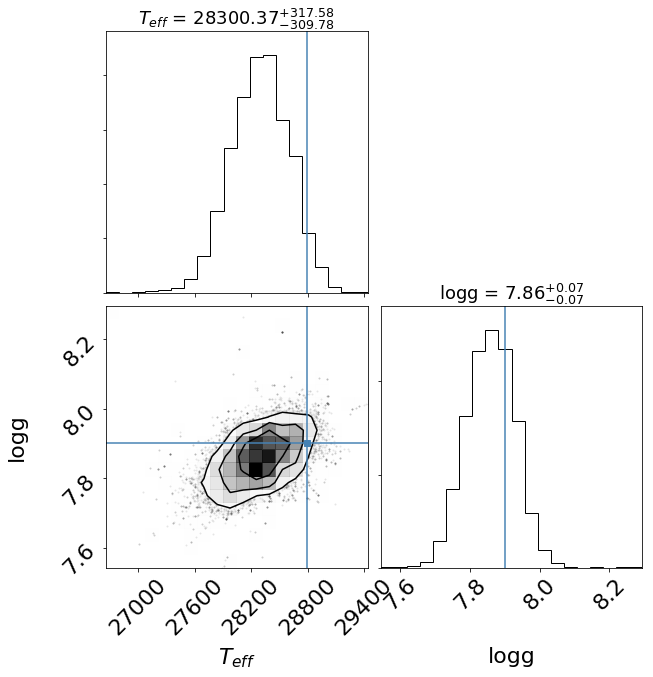

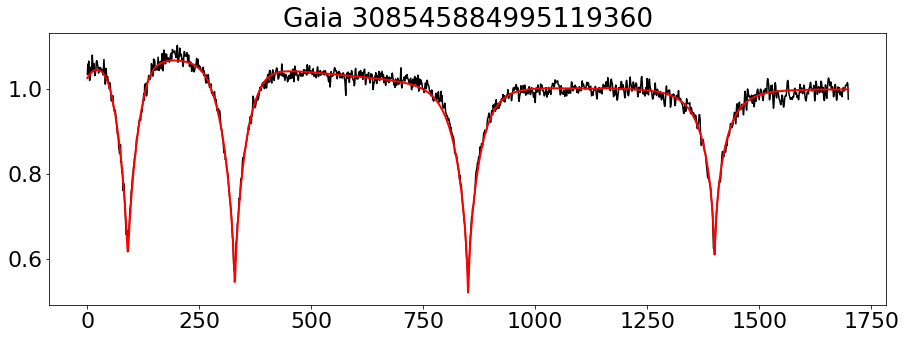

 20%|██        | 1/5 [00:24<01:37, 24.47s/it]

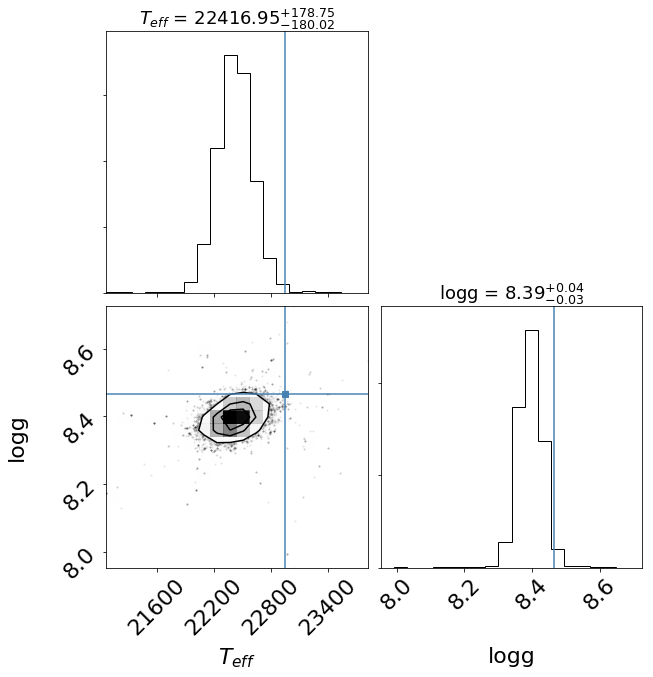

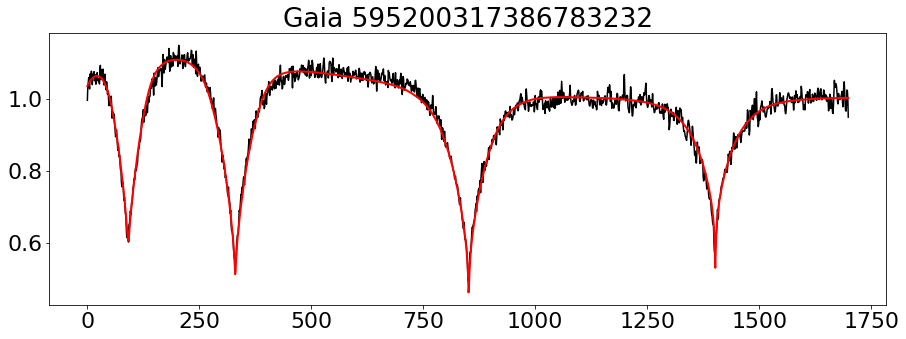

 40%|████      | 2/5 [00:48<01:12, 24.33s/it]

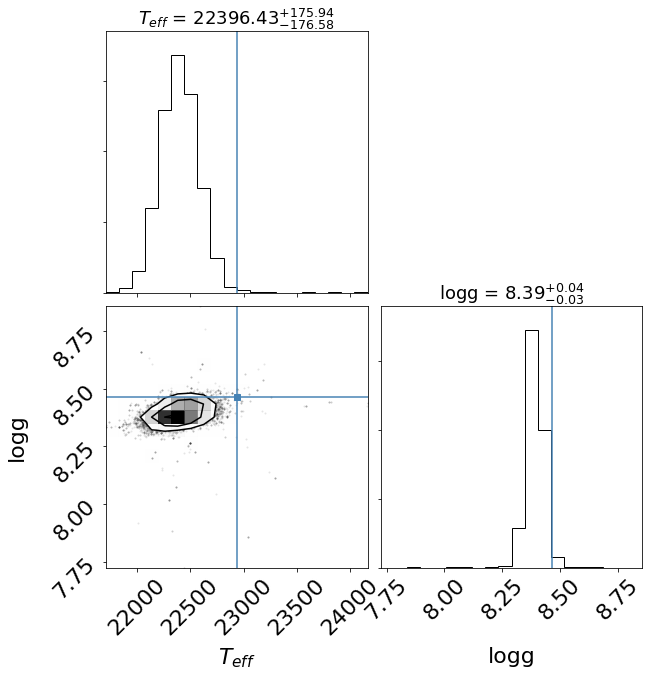

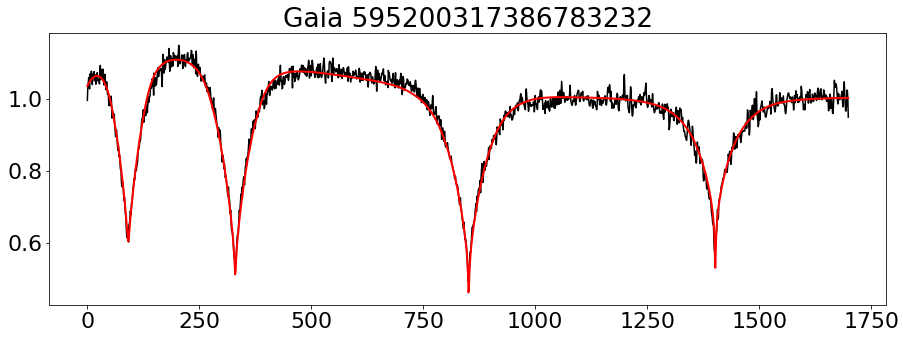

 60%|██████    | 3/5 [01:11<00:47, 23.90s/it]

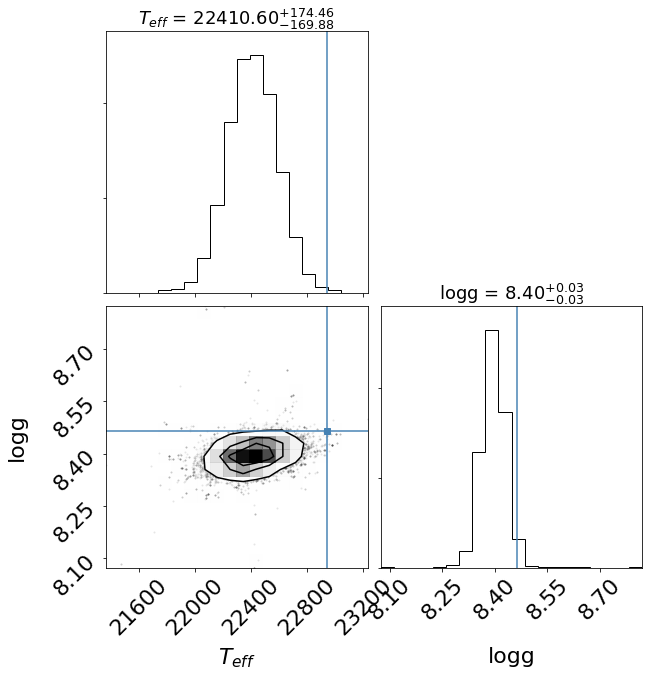

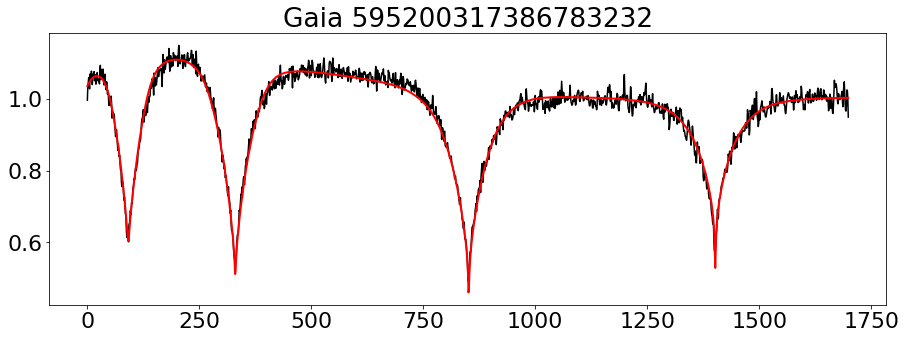

 80%|████████  | 4/5 [01:36<00:24, 24.22s/it]

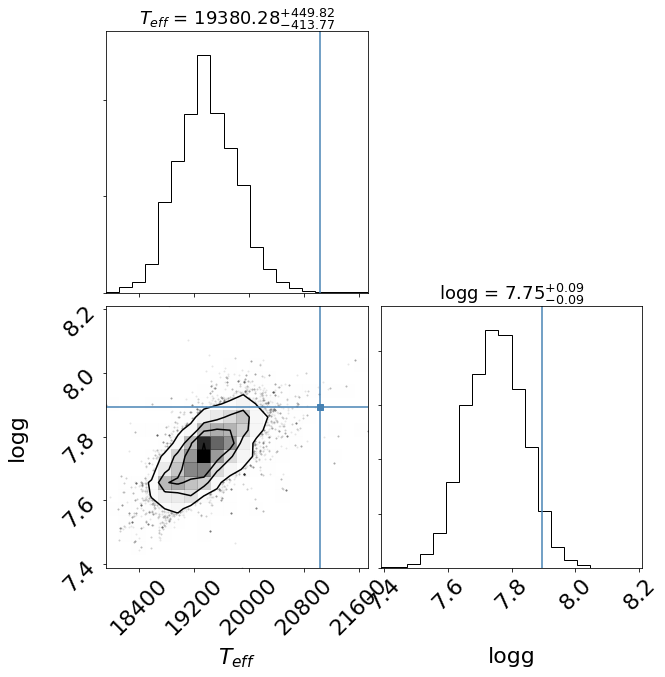

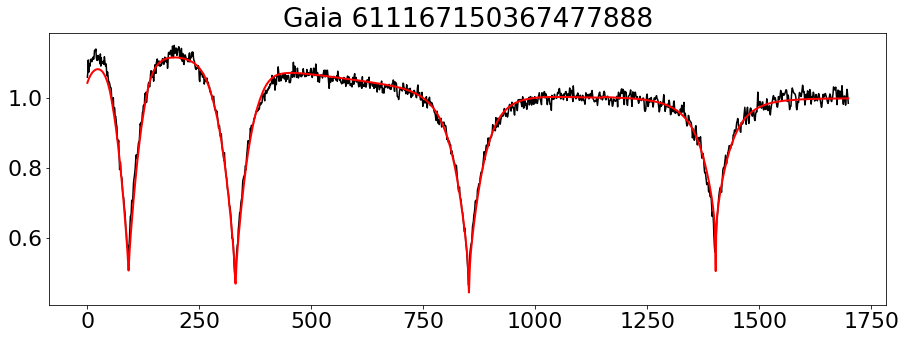

100%|██████████| 5/5 [01:57<00:00, 23.41s/it]


In [225]:
results = [];
for ii in tqdm(range(len(wdtable[0:5]))):
    spec = interpfluxs[ii]
    sig = sigs[ii]
    normspec,normsig = norm_dataspec(spec,sig)
    normspec = normspec[lines]
    normsig = normsig[lines]
    teff_prior = get_prior_teff(spec)

    def lnlike(prms):
        err = normsig
        model = norm_spectrum_sampler(lamgrid,prms[0],prms[1],prms[2])
        diff = model - normspec
        diff = diff[~np.isnan(model)]
        err = err[~np.isnan(model)]
        chisq = np.sum(diff**2/err)
        lnlike = -0.5 * chisq

    #     plt.plot(model)
    #     plt.plot(normspec)
        return lnlike

    def lnprior(prms):
        if prms[0] < 6000 or prms[0] > 50000:
            return -np.Inf
        elif prms[1] < 6.5 or prms[1] > 9.5:
            return -np.Inf
        elif prms[2] < -3 or prms[2] > 3:
            return -np.Inf

        mu = teff_prior
        sigma = 1000
        return 0#np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(prms[0]-mu)**2/sigma**2

    def lnprob(prms):
        lp = lnprior(prms)
        if not np.isfinite(lp):
            return -np.Inf
        return lp + lnlike(prms)


    ndim,nwalkers = 3,50


    steps = 250
    burn = 10
    
    nll = lambda *args: -lnprob(*args)

    #p = scipy.optimize.minimize(nll, x0 = [teff_prior, 8., 0],\
    #                       method = 'Powell')
    
    p = scipy.optimize.dual_annealing(nll,bounds = [(5500,80000),(6.5,9.5),(-3,3)],maxfun = 3000,\
                                      x0 = [teff_prior, 8., 0])
    
    param_disps = [0.05]*3
    #p0 = np.asarray(get_posteriors(spec))
    p0 = p.x
    pos0 = np.zeros((nwalkers,ndim))
    for jj in range(ndim):
        pos0[:,jj] = ( p0[jj] + param_disps[jj]*p0[jj]*np.random.randn(nwalkers) )
        
        

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,threads = 1)
    b = sampler.run_mcmc(pos0,burn)
    sampler.reset()
    s = sampler.run_mcmc(b[0],steps)
    values = np.median(sampler.flatchain,0)
    meanvalues = np.mean(sampler.flatchain,0)
    modevalues = stats.mode(sampler.flatchain,0)[0]
    mlevalues = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    lower = np.quantile(sampler.flatchain,.3173,axis=0)
    upper = np.quantile(sampler.flatchain,.6827,axis=0)
    std = np.std(sampler.flatchain,axis=0)
    
    results.append([values, meanvalues, modevalues, mlevalues, lower, upper, std])
    
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    #f = corner.corner(sampler.flatchain[:,0:2],show_titles = True,smooth = 0,labels = ('$T_{eff}$','logg'),title_kwargs={'fontsize':18}, fig = fig)
    f = corner.corner(sampler.flatchain[:,0:2],show_titles = True,smooth = 0,truths = (wdtable['spec_Teff'][ii],wdtable['spec_logg'][ii]),labels = ('$T_{eff}$','logg'),title_kwargs={'fontsize':18}, fig = fig)
    plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_corner.png')

    plt.figure(figsize = (15,5))
    plt.title('Gaia '+str(wdtable[ii]['source_id']))
    plt.plot(normspec,'k', label = 'Data Spectrum')
    plt.plot(norm_spectrum_sampler(lamgrid,mlevalues[0],mlevalues[1],mlevalues[2]),'r',label = 'Fitted Synthetic',linewidth=2)
    #plt.legend()
    plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_fit.png')
    #plt.close()
    plt.show()

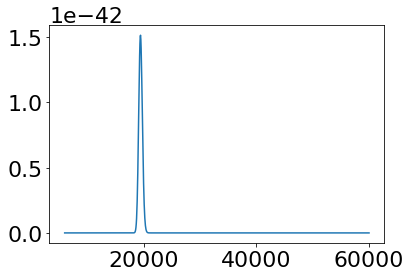

In [226]:
ts = np.linspace(6000,60000,1000)
liks = [lnprob([i,7.74,0]) for i in ts]

plt.plot(ts,np.exp(liks))

In [227]:
p0

array([1.93975751e+04, 7.74203551e+00, 2.22769799e-01])

In [228]:
results = np.asarray(results)
mles = results[:,3]
lowers = results[:,4]
uppers = results[:,5]
stds = results[:,6]

In [229]:
mles

array([array([2.83139990e+04, 7.87010426e+00, 1.18852403e-01]),
       array([2.24050590e+04, 8.39485685e+00, 1.93566882e-01]),
       array([2.23789260e+04, 8.39090573e+00, 1.93814826e-01]),
       array([2.23808658e+04, 8.39408490e+00, 1.92783232e-01]),
       array([1.93615311e+04, 7.73487471e+00, 2.24663458e-01])],
      dtype=object)

In [230]:
meanvalues

array([1.93951549e+04, 7.74818495e+00, 2.19216153e-01])

### Compare to Tremblay

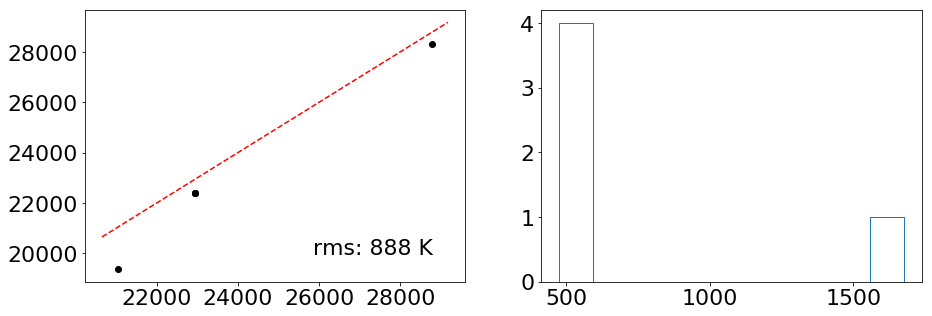

In [232]:
plt.rcParams.update({'font.size': 22})

mlespec_Teff = [i[0] for i in mles]
lowspec_Teff = [i[0] for i in stds]
highspec_Teff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, color = 'k')
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

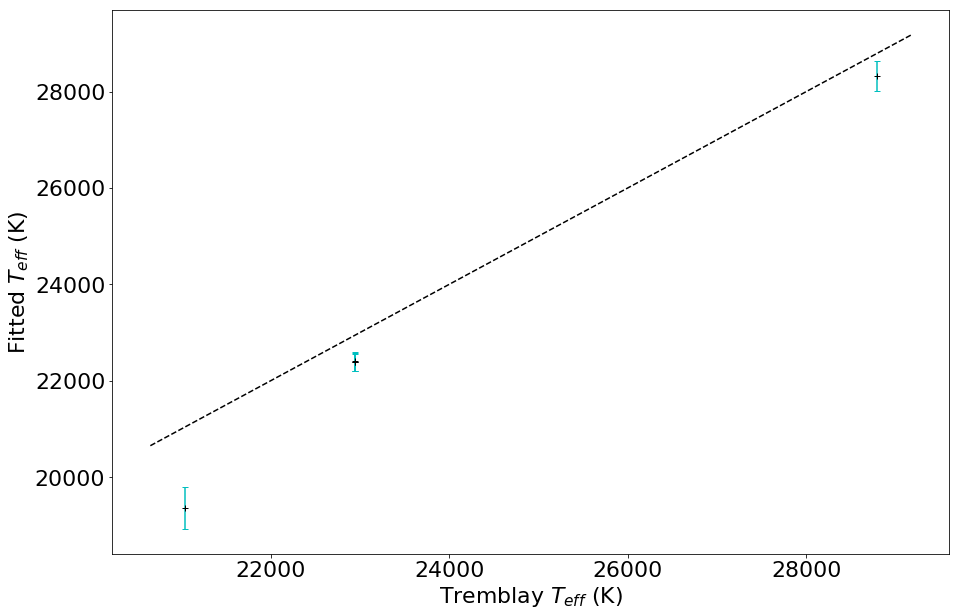

In [233]:
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, yerr = (lowspec_Teff,highspec_Teff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

965.3365958828225

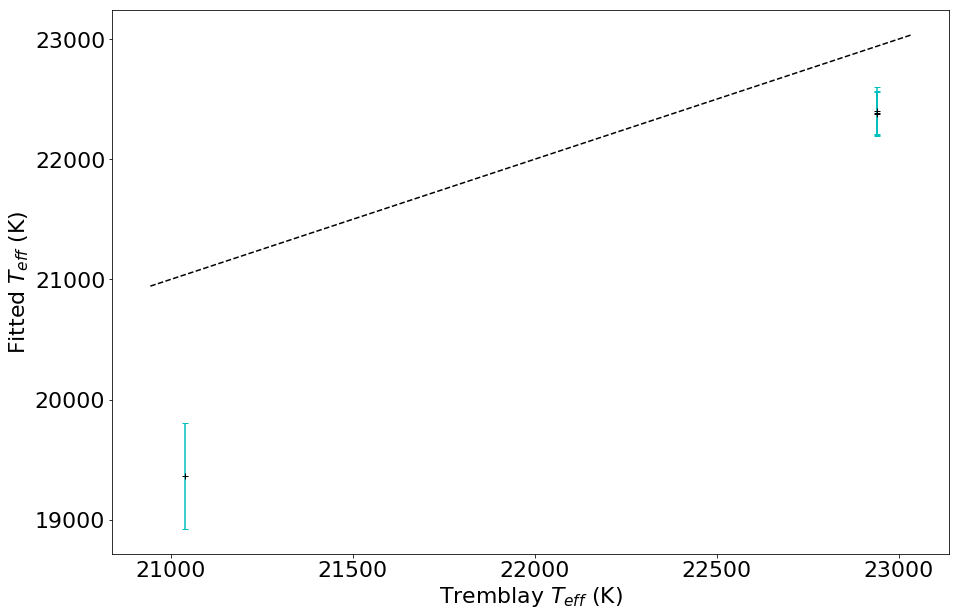

In [234]:
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)][mask]-np.asarray(mlespec_Teff)[mask]
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)][mask],np.asarray(mlespec_Teff)[mask], yerr = (np.asarray(lowspec_Teff)[mask],np.asarray(highspec_Teff)[mask]), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')
rms

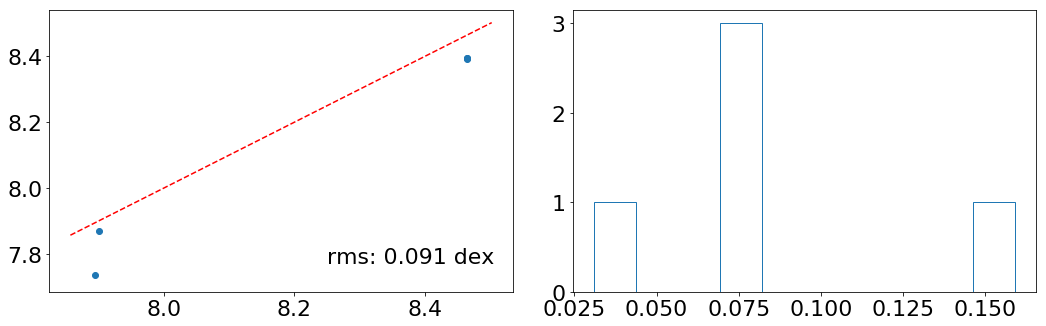

In [235]:
mlespec_logg = [i[1] for i in mles]
lowspec_logg = [i[1] for i in stds]
highspec_logg = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['spec_logg'][0:len(mles)],mlespec_logg)
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

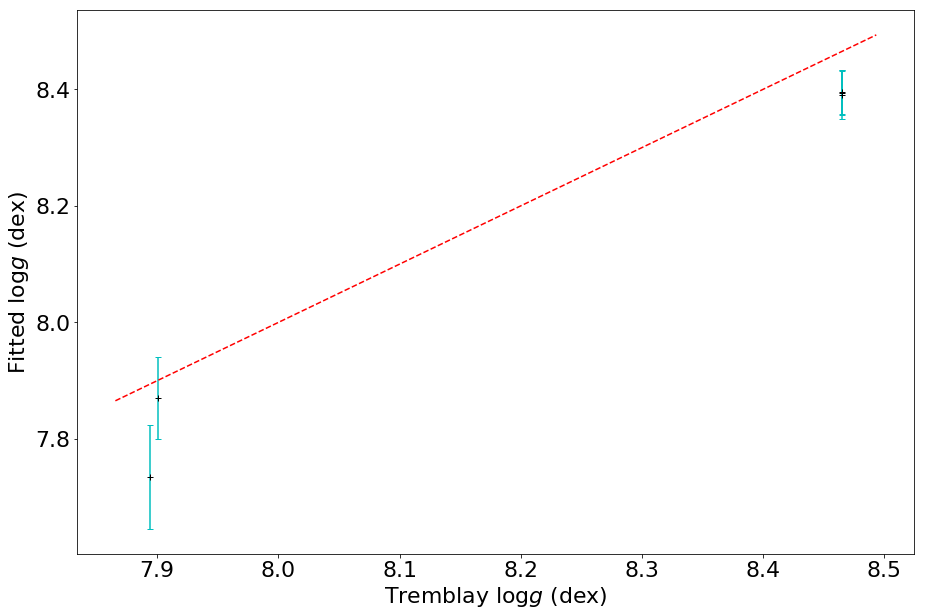

In [236]:
mlespec_logg = [i[1] for i in mles]
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_logg'][0:len(mles)],mlespec_logg, yerr = (lowspec_logg,highspec_logg), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')

In [67]:
pickle.dump(results,open('223wdfits.p','wb'))

In [68]:
results = pickle.load(open('223wdfits.p','rb'))

### Compare to Fusilio

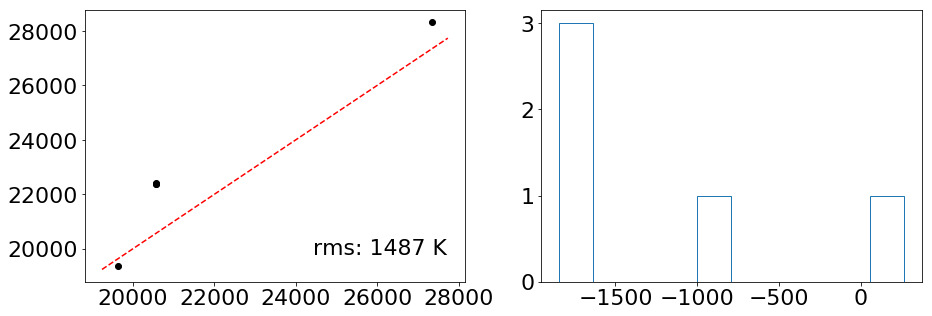

In [238]:
mleteff = [i[0] for i in mles]
lowteff = [i[0] for i in stds]
highteff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['Teff'][0:len(mles)],mleteff, color = 'k')
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

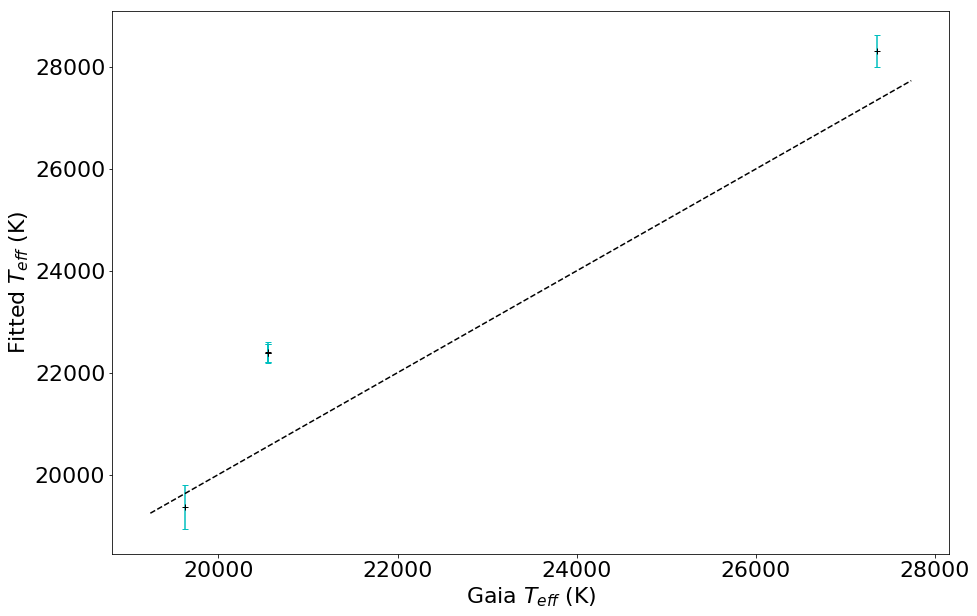

In [239]:
mleteff = [i[0] for i in mles]
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['Teff'][0:len(mles)],mleteff, yerr = (lowteff,highteff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Gaia $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

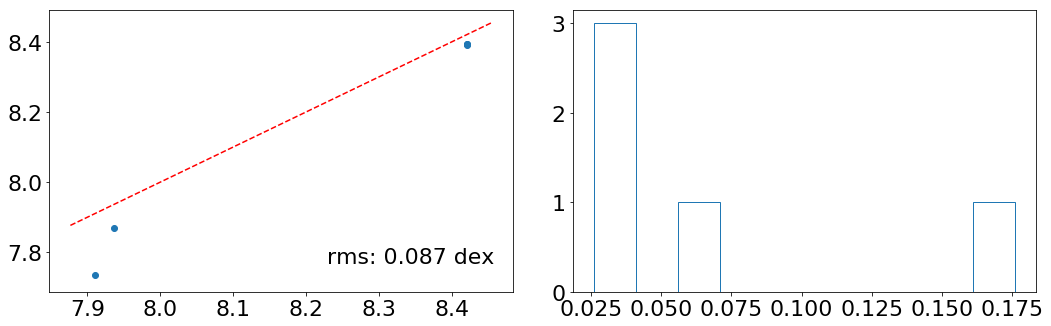

In [240]:
mlelog_g = [i[1] for i in mles]
lowlog_g = [i[1] for i in stds]
highlog_g = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['log_g'][0:len(mles)],mlelog_g)
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

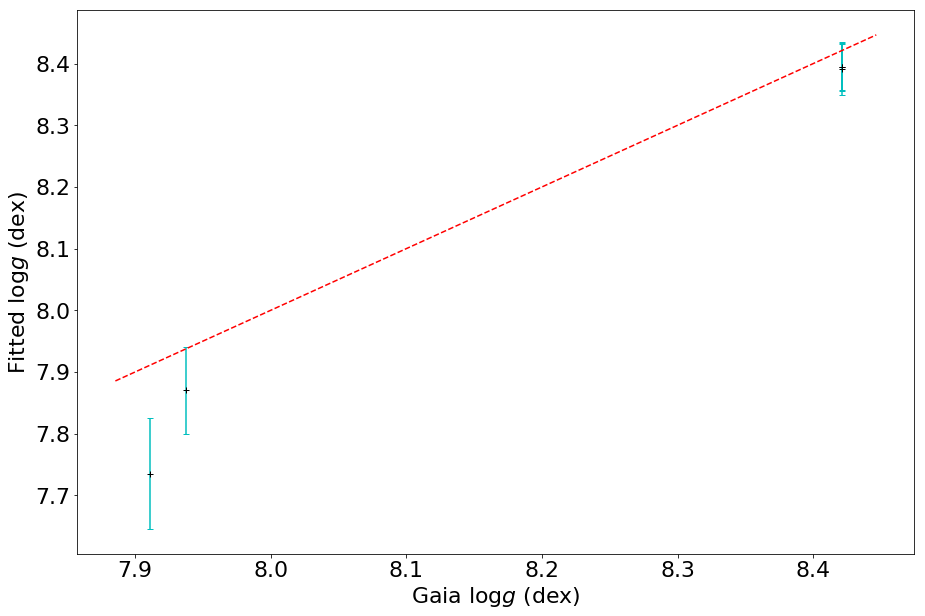

In [241]:
mlelog_g = [i[1] for i in mles]
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['log_g'][0:len(mles)],mlelog_g, yerr = (lowlog_g,highlog_g), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Gaia $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')